In [142]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from music21.duration import Duration
from music21.instrument import Instrument
from music21.note import Note, Rest
from music21.stream import Stream
from music21.tempo import MetronomeMark
import numpy as np
import os
import scipy.io.wavfile

from generate_audio_samples import make_instrument, write_midi
from midi2audio import FluidSynth

In [143]:
mpl.rc('figure', figsize=(20, 10))

In [26]:
midi_notes = np.arange(128)
instruments = np.arange(128)

In [29]:
def sweep_instrument(instrument_id, output_dir):
    s = Stream()
    duration = Duration(1.0)
    s.append(make_instrument(instrument_id))
    s.append(MetronomeMark(number=120))
    for midi_number in midi_notes:
        s.append(Note(midi=midi_number, duration=duration))
        s.append(Rest(duration=duration))
    os.makedirs(output_dir, exist_ok=True)
    midi_file, audio_file = [
        output_dir + '/instrument_{0:03d}.{1}'.format(instrument_id, ext)
        for ext in ['midi', 'wav']]
    write_midi(s, midi_file)
    print('instrument:', audio_file)
    FluidSynth().midi_to_audio(midi_file, audio_file)

def sweep_instruments(output_dir):
    for instrument_id in instruments:
        sweep_instrument(instrument_id, output_dir)

In [120]:
audio_dir = 'data/working/instrument-ranges'
sweep_instruments(audio_dir)

instrument: data/working/instrument_ranges/instrument_000.wav
instrument: data/working/instrument_ranges/instrument_001.wav
instrument: data/working/instrument_ranges/instrument_002.wav
instrument: data/working/instrument_ranges/instrument_003.wav
instrument: data/working/instrument_ranges/instrument_004.wav
instrument: data/working/instrument_ranges/instrument_005.wav
instrument: data/working/instrument_ranges/instrument_006.wav
instrument: data/working/instrument_ranges/instrument_007.wav
instrument: data/working/instrument_ranges/instrument_008.wav
instrument: data/working/instrument_ranges/instrument_009.wav
instrument: data/working/instrument_ranges/instrument_010.wav
instrument: data/working/instrument_ranges/instrument_011.wav
instrument: data/working/instrument_ranges/instrument_012.wav
instrument: data/working/instrument_ranges/instrument_013.wav
instrument: data/working/instrument_ranges/instrument_014.wav
instrument: data/working/instrument_ranges/instrument_015.wav
instrume

In [181]:
def analyze_instrument_rms(i, audio_dir):
    """
    Compute the RMS of each note in the synthesized signal for a single instrument.
    """
    fs, x = scipy.io.wavfile.read('{0}/instrument_{1:03d}.wav'.format(audio_dir, i))
    # convert from stereo to mono
    x = x.mean(axis=1)
    # cut the leading rest
    x = x[fs // 2:]
    # align the ending
    x = x[:len(x) // fs * fs]
    # split the notes
    x_notes = x.reshape(-1, fs)
    # RMS for each note
    x_notes_rms = np.sqrt((x_notes**2).mean(axis=1))
    return x_notes_rms

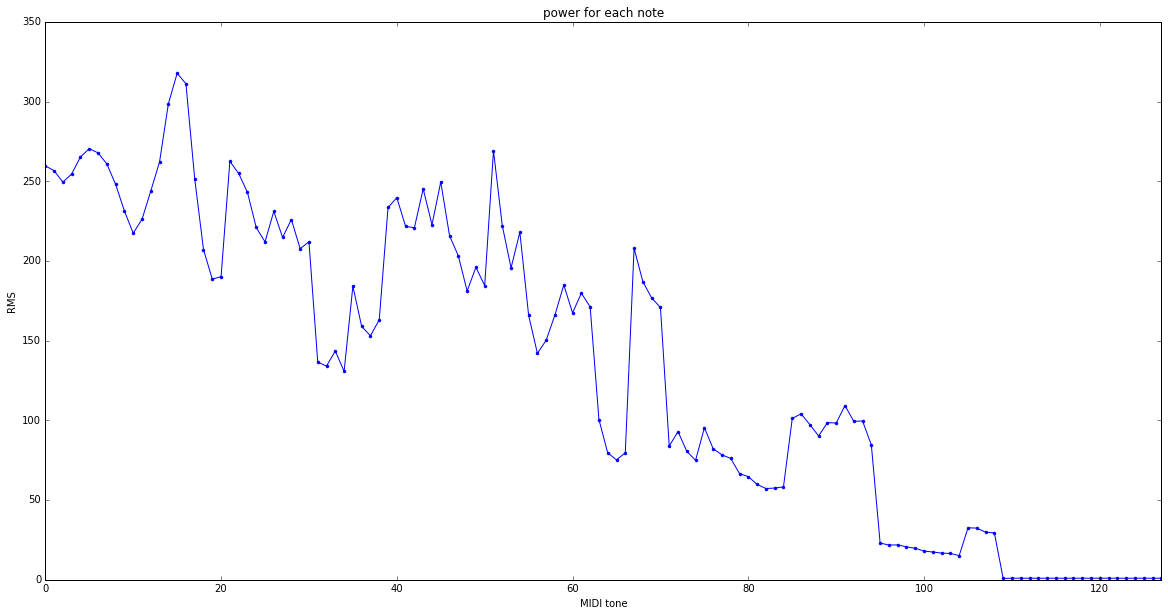

In [182]:
plt.plot(analyze_instrument_rms(1, audio_dir), '.-')
plt.title('power for each note')
plt.xlabel('MIDI tone')
plt.ylabel('RMS')
plt.xlim(0,127);

In [183]:
def analyze_rms_for_all_instruments(audio_dir):
    """
    Compute a matrix of RMS for each instrument and note.
    """
    return np.vstack([analyze_instrument_rms(i, audio_dir) for i in instruments])

In [184]:
x_rms_instruments_notes = analyze_rms_for_all_instruments(audio_dir)

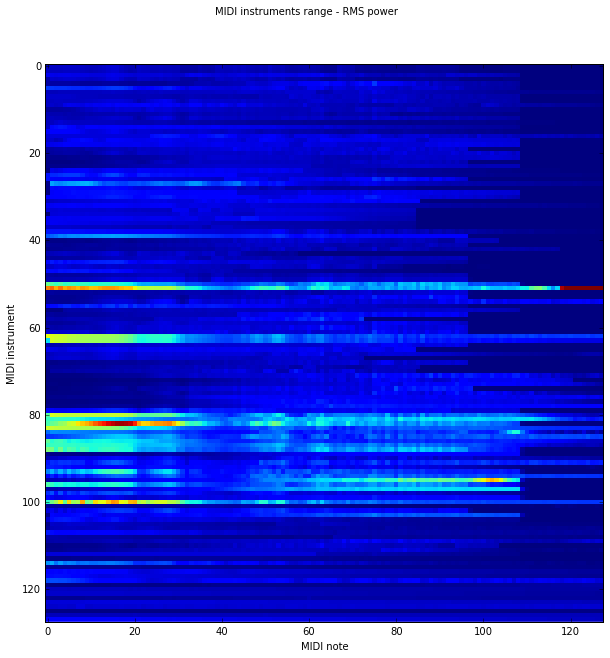

In [185]:
plt.imshow(x_rms_instruments_notes, interpolation='none')
plt.suptitle('MIDI instruments range - RMS power')
plt.xlabel('MIDI note')
plt.ylabel('MIDI instrument')
plt.savefig('data/working/instrument_ranges_rms.png');

In [186]:
np.save('data/working/instrument_ranges_rms.npy', x_rms_instruments_notes)

There's a peak at value around 1.0 which represents quiet.

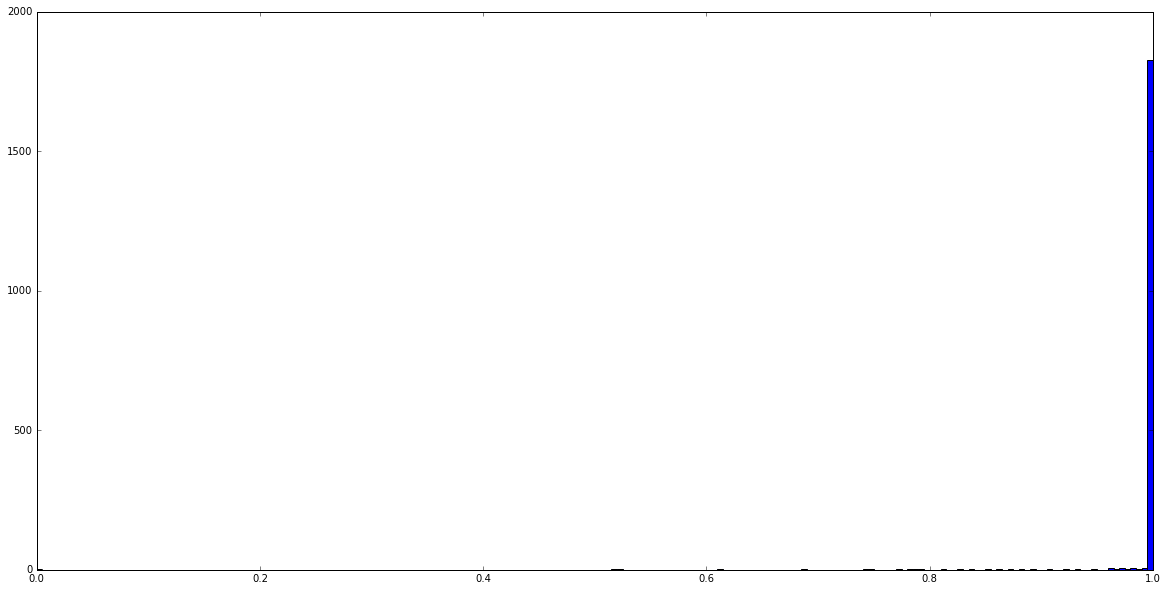

In [193]:
plt.hist(x_rms_instruments_notes[x_rms_instruments_notes <= 1].flatten(), 200);

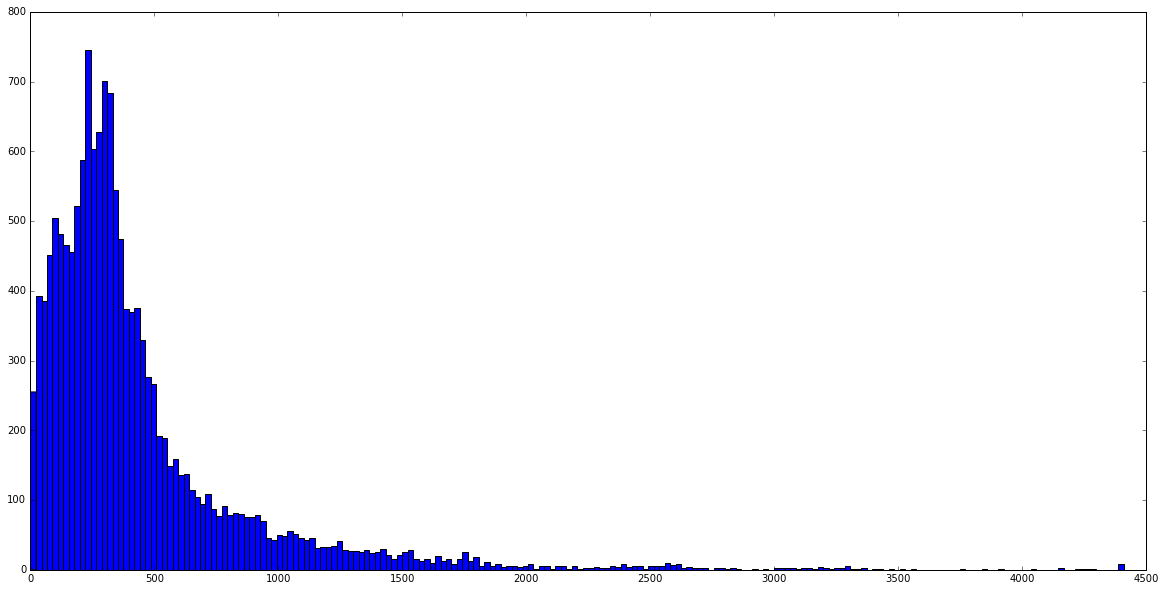

In [194]:
plt.hist(x_rms_instruments_notes[x_rms_instruments_notes > 1].flatten(), 200);

The range of instruments split into quiet (black) and sounding (white) regions. We can limit the pitches to the sounding ones.

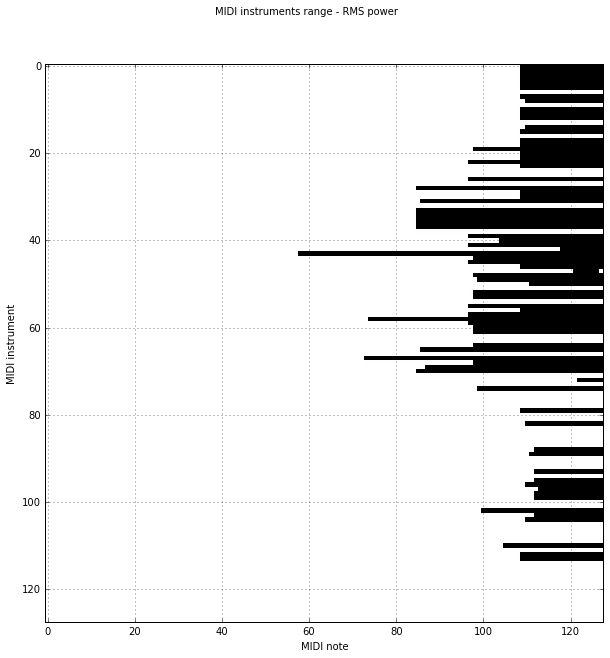

In [197]:
plt.imshow(x_rms_instruments_notes > 1, interpolation='none', cmap='gray')
plt.grid(True)
plt.suptitle('MIDI instruments range - RMS power')
plt.xlabel('MIDI note')
plt.ylabel('MIDI instrument')
plt.savefig('data/working/instrument_ranges_binary.png');